# Stitching thermal drone imagery

In [2]:
# Variable definition
imgDir = 'data/lsm/Flight 1 - Library/'
pathFile = 'data/lsm/Flight 1.csv'
utcDiff = -1
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)']
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)'
imgTimes = [1619811011923,1619811099149] # Specify times if wanted
utmZone, hemisphere = '31n', 'north'
pxSize = 0.27 # pixel size (m) - for now
distFilt = False
resolutions = [2, 6, 60]

In [3]:
# Import packages
#%pip install opencv-python
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
#import cv2 as cv

In [4]:
## Retrieve images and path information
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(('.jpg','.png','.tif'))]
imgs.sort()
pathDf = pd.read_csv(pathFile)

In [5]:
## Get corresponding GPS info matched with images
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]
# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['y'], merged['x'] = myProj(merged['longitude'].values, merged['latitude'].values)

In [23]:
# Coordinates from initial and speed
init = merged.iloc[0]
pi1 = pathDf.loc[pathDf['timestamp']==init['timestamp']].index[0]
meas = merged.iloc[1]
pi2 = pathDf.loc[pathDf['timestamp']==meas['timestamp']].index[0]
vels = pathDf.loc[pi1:pi2][['velocityX(mps)','velocityY(mps)']].mean()

In [24]:
vels

velocityX(mps)   -0.100000
velocityY(mps)   -5.336364
dtype: float64

In [17]:
pathDf.loc[pathDf['timestamp']==init['timestamp']].index[0]

510

In [25]:
init

imgPath        data/lsm/Flight 1 - Library/20210430_203012_R.jpg
timestamp                                            1.61981e+12
latitude                                                 52.2047
longitude                                               0.108394
altitude(m)                                                  120
pitch(deg)                                                 -11.4
roll(deg)                                                    3.7
yaw(deg)                                                   -91.5
y                                                         302417
x                                                    5.78774e+06
Name: 51, dtype: object

In [ ]:
# Orientation correction
dist = merged['altitude(m)']*np.tan(np.deg2rad(merged['pitch(deg)']))
merged['xc'], merged['yc'] = merged.x+(dist*np.sin(np.deg2rad(merged['yaw(deg)']))), merged.y+(dist*np.cos(np.deg2rad(merged['yaw(deg)'])))
if distFilt: merged = merged[abs(dist) < distFilt]

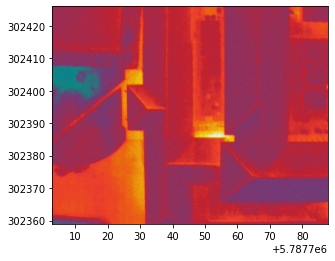

In [397]:
# Single image
val = 0.27
downsample = int(np.floor(val/pxSize))
imgEx = ro.open(merged.iloc[0]['imgPath'])
read = imgEx.read()
imgExArr = np.dstack((read[0],read[1],read[2]))
ds_array = imgExArr/255
rEx = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)

# Get x,y coordinates for each pixel
yCoords, xCoords = [(np.array(range(rEx.shape[i]))-(rEx.shape[i]/2))*val+val/2 for i in [0,1]]
xq, yq = int(np.floor(len(xCoords)/4)), int(np.floor(len(yCoords)/4))
xmCoords, ymCoords = np.meshgrid(xCoords[xq:3*xq],yCoords[yq:3*yq])
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

row = merged.iloc[5]
impImg = ro.open(row.imgPath)
img = impImg.read()[:,yq:3*yq,xq:3*xq]
imgst = np.dstack((img[0],img[1],img[2]))/255
total = np.concatenate((xmcr+row.xc, ymcr+row.yc,imgst[:,:,0].reshape(-1,1),imgst[:,:,1].reshape(-1,1),imgst[:,:,2].reshape(-1,1)),axis=-1)
extent = (np.ceil(min(total[:,0])), np.floor(max(total[:,0])),np.ceil(min(total[:,1])),np.floor(max(total[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])
rs = np.dstack((total[:,2].reshape(2*yq,2*xq),total[:,3].reshape(2*yq,2*xq),total[:,4].reshape(2*yq,2*xq)))
plt.imshow(rs,extent=extent)

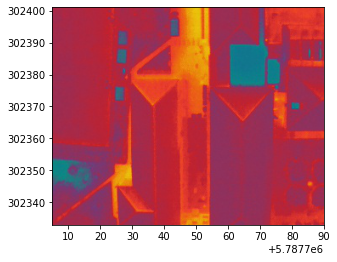

In [398]:
row2 = merged.iloc[10]
impImg2 = ro.open(row2.imgPath)
img2 = impImg2.read()[:,yq:3*yq,xq:3*xq]
imgst2 = np.dstack((img2[0],img2[1],img2[2]))/255
total2 = np.concatenate((xmcr+row2.xc, ymcr+row2.yc,imgst2[:,:,0].reshape(-1,1),imgst2[:,:,1].reshape(-1,1),imgst2[:,:,2].reshape(-1,1)),axis=-1)
extent2 = (np.ceil(min(total2[:,0])), np.floor(max(total2[:,0])),np.ceil(min(total2[:,1])),np.floor(max(total2[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])
rs2 = np.dstack((total2[:,2].reshape(2*yq,2*xq),total2[:,3].reshape(2*yq,2*xq),total2[:,4].reshape(2*yq,2*xq)))
plt.imshow(rs2,extent=extent2)

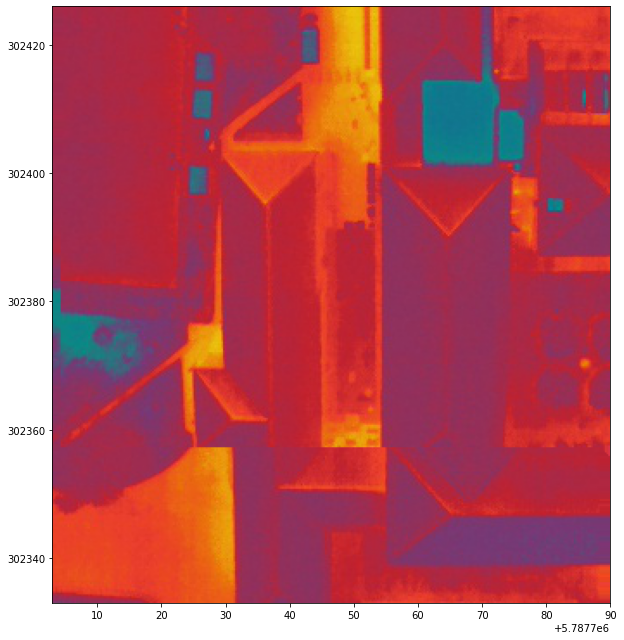

In [399]:
alltot = np.vstack((total, total2))
extot = (np.ceil(min(alltot[:,0])), np.floor(max(alltot[:,0])),np.ceil(min(alltot[:,1])),np.floor(max(alltot[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])

xsGrid = np.arange(extot[0], extot[1], val)
ysGrid = np.arange(extot[2], extot[3], val)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

method = 'nearest'
r,g,b = [griddata(alltot[1:,:2], alltot[1:,i], (xsGridm, ysGridm), method=method) for i in [2,3,4]]

# Plot 
fig, ax = plt.subplots(1,1,figsize=[10,15])
#extent = (np.ceil(min(total[:,0])), np.floor(max(total[:,0])),np.ceil(min(total[:,1])),np.floor(max(total[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])

plt.imshow(np.dstack((r, g, b)),extent=extot)

10it [00:00, 44.61it/s]


Text(0.5, 1.0, 'Interpolation to grid using every 3 images')

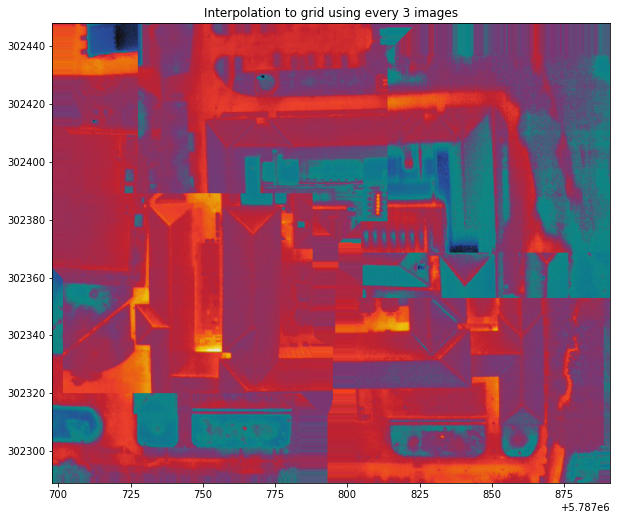

In [418]:
# Loop over resolution to create combined image for each
# Initial setup and downsampling if desired
val = 0.27
downsample = int(np.floor(val/pxSize))
imgEx = ro.open(merged.iloc[0]['imgPath'])
read = imgEx.read()
imgExArr = np.dstack((read[0],read[1],read[2]))
ds_array = imgExArr/255
rEx = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
# Get x,y coordinates for each pixel
yCoords, xCoords = [(np.array(range(rEx.shape[i]))-(rEx.shape[i]/2))*val+val/2 for i in [0,1]]
xq, yq = int(np.floor(len(xCoords)/4)), int(np.floor(len(yCoords)/4))
xmCoords, ymCoords = np.meshgrid(xCoords[xq:3*xq],yCoords[yq:3*yq])
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

# Loop over images
skip=3
alltot = [0,0,0,0,0]
for index, row in tqdm(merged[::skip].iterrows()):
    img = ro.open(row.imgPath)
    read = img.read()[:,yq:3*yq,xq:3*xq]
    imgst = np.dstack((read[0],read[1],read[2]))/255
    total = np.concatenate((xmcr+row.xc, ymcr+row.yc,imgst[:,:,0].reshape(-1,1),imgst[:,:,1].reshape(-1,1),imgst[:,:,2].reshape(-1,1)),axis=-1)
    alltot = np.vstack((alltot,total))

alltot = alltot[1:,:]
extot = (np.ceil(min(alltot[:,0])), np.floor(max(alltot[:,0])),np.ceil(min(alltot[:,1])),np.floor(max(alltot[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])

xsGrid = np.arange(extot[0], extot[1], val)
ysGrid = np.arange(extot[2], extot[3], val)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

method = 'nearest'
r,g,b = [griddata(alltot[1:,:2], alltot[1:,i], (xsGridm, ysGridm), method=method) for i in [2,3,4]]

# Plot 
fig, ax = plt.subplots(1,1,figsize=[10,10])

ax.imshow(np.dstack((r, g, b)),extent=extot)
ax.set_title('Interpolation to grid using every '+str(skip)+' images')

In [419]:
fig.savefig('plots/coordCorrectedFilt'+str(skip))

In [ ]:
# Plot example downsampled image
for i, val in enumerate(resolutions):
    downsample = int(np.floor(val/pxSize))
    # first, change to 0-1
    ds_array = imgExArr/255
    r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
    g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
    b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
    ds_array = np.stack((r, g, b), axis=-1)
    if i<2:
        c = axs[1,i].imshow(ds_array)
        axs[1,i].set_title('Image {} downsampled to {} m resolution'.format(str(imageNum),val))
plt.show()